In [1]:
import Tom_Model as TM
import pandas as pd
import numpy as np
import random

from collections import defaultdict
from copy import deepcopy

from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

import matplotlib.pyplot as plt
from pandas.plotting import table

from tabulate import tabulate

from matplotlib.offsetbox import OffsetImage, AnnotationBbox

In [2]:
theta = 1.7

In [3]:
table_file = 'wc_info.csv'

In [4]:
wc_group_table = pd.read_csv(table_file, header=0)

wc_group_table['Points'] = 0

wc_group_table = wc_group_table.set_index('Code')

In [5]:
possible_years = [2014, 2018, 2022]

year = input('What year do you want to simulate? [2014, 2018, 2022]')

if int(year) in possible_years:
    group_table = wc_group_table[wc_group_table['Year'] == int(year)]
    schedule_file = f'{year}_wc_schedule.csv'
else:
    print('Please pick a valid year.')

What year do you want to simulate? [2014, 2018, 2022]2022


In [6]:
group_table = TM.need_new_elo(group_table)

Use Current Elos (Y/N)? Y


/Users/thomasgaudin/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [7]:
matches = pd.read_csv(schedule_file, header=0)

init_matches = deepcopy(matches)

In [8]:
team_tuples = [(x, y) for x, y in zip(group_table['Group'], group_table.index)]

cols = pd.MultiIndex.from_tuples(team_tuples)

#Create dataframe with MultiIndex columns
placement_table = pd.DataFrame(0,
                            index = np.arange(1, 5),
                            columns = cols)

#finish table
finish_table = pd.DataFrame(0,
                            index = group_table.index,
                            columns = ['R16', 'QF', 'SF', '3rd', '2nd', '1st'])

In [9]:
#initialize lists, dictionaries, arrays

groups = ["A", "B", "C", "D", "E", "F", "G", "H"]

init_group_table = deepcopy(group_table)

total_table = group_table.loc[:, ['Points', 'Group']].copy()

total_table['QF'] = 0
total_table['SF'] = 0
total_table['3rd'] = 0
total_table['2nd'] = 0
total_table['1st'] = 0

In [10]:
group_stage = matches[matches['Match Num'] < 49]

In [11]:
num_group_matches = 3
iterations = 10000

host = group_table[group_table['Host'] == 'Y'].index[0]

groups_dict = {'A': [49, 51], 'B': [51, 49], 'C': [50, 52], 'D': [52, 50], 
               'E': [53, 55], 'F': [55, 53], 'G': [54, 56], 'H': [56, 54]}

kos_dict = {'49': [57, 'Home'], '50': [57, 'Away'], '51': [59, 'Home'], '52': [59, 'Away'], 
            '53': [58, 'Home'], '54': [58, 'Away'], '55': [60, 'Home'], '56': [60, 'Away'], 
            '57': [61, 'Home'], '58': [61, 'Away'], '59': [62, 'Home'], '60': [62, 'Away'],
            '61': [64, 'Home'], '62': [64, 'Away']}

In [12]:
for match in (group_stage['Match Num']-1):
        
    #calculate win expectancies
    home_team, home_we, home_elo, away_team, away_we, away_elo = TM.calc_neutral_match_We(group_stage, 
                                                                   match, group_table, host)

    #Determine win probability for each team
    home_wp = TM.davidson_home_wp(home_we, away_we, theta)
    away_wp = TM.davidson_away_wp(home_we, away_we, theta)
    draw_wp = TM.davidson_tie_prob(home_we, away_we, theta)
    
    print(f"{home_team} / Draw / {away_team}")
    print(f"{round(home_wp,2)} / {round(draw_wp,2)} / {round(away_wp,2)}")

Senegal / Draw / Netherlands
0.14 / 0.18 / 0.68
England / Draw / Iran
0.65 / 0.19 / 0.16
Qatar / Draw / Ecuador
0.11 / 0.15 / 0.73
United_States / Draw / Wales
0.51 / 0.24 / 0.25
Argentina / Draw / Saudi_Arabia
0.96 / 0.03 / 0.02
Denmark / Draw / Tunisia
0.57 / 0.22 / 0.21
Mexico / Draw / Poland
0.55 / 0.23 / 0.22
France / Draw / Australia
0.81 / 0.11 / 0.07
Morocco / Draw / Croatia
0.24 / 0.24 / 0.52
Germany / Draw / Japan
0.39 / 0.26 / 0.35
Spain / Draw / Costa_Rica
0.86 / 0.09 / 0.05
Belgium / Draw / Canada
0.73 / 0.16 / 0.11
Switzerland / Draw / Cameroon
0.67 / 0.18 / 0.14
Uruguay / Draw / South_Korea
0.61 / 0.21 / 0.18
Portugal / Draw / Ghana
0.89 / 0.07 / 0.04
Brazil / Draw / Serbia
0.69 / 0.18 / 0.14
Wales / Draw / Iran
0.22 / 0.23 / 0.55
Qatar / Draw / Senegal
0.21 / 0.23 / 0.56
Netherlands / Draw / Ecuador
0.5 / 0.24 / 0.26
England / Draw / United_States
0.68 / 0.18 / 0.14
Tunisia / Draw / Australia
0.31 / 0.25 / 0.44
Poland / Draw / Saudi_Arabia
0.61 / 0.21 / 0.18
France / Dr

In [15]:
for iteration in range(iterations):
    for match in (group_stage['Match Num']-1):
        
        #calculate win expectancies
        home_team, home_we, home_elo, away_team, away_we, away_elo = TM.calc_neutral_match_We(group_stage, 
                                                                       match, group_table, host)
        
        #Determine win probability for each team
        home_wp = TM.davidson_home_wp(home_we, away_we, theta)
        away_wp = TM.davidson_away_wp(home_we, away_we, theta)
        draw_wp = TM.davidson_tie_prob(home_we, away_we, theta)

    
        group_table = TM.play_gs_match_neutral(group_table, home_team, home_we, home_elo, home_wp, 
                          away_team, away_we, away_elo, away_wp, draw_wp)
            
    
    for team in group_table.index:
        team_points = group_table.loc[team, 'Points']
        total_table.loc[team, 'Points'] += team_points
        
    for group in groups:
        
        group_tab = group_table[group_table['Group'] == group]
        ranked_group_tab = group_tab.sort_values(by='Points', ascending=False)
        ranked_group_tab['Rank'] = group_tab['Points'].rank(method='max', ascending = False)
        
        for team in ranked_group_tab.index:
            rank = ranked_group_tab.loc[team, 'Rank']
            group = ranked_group_tab.loc[team, 'Group']
            
            placement_table.loc[rank, (group, team)] += 1
        
        #assign teams to knockout games:
        
        #winner goes to a match first
        winner_match = groups_dict[group][0]-1
        matches.loc[winner_match, 'Home'] = ranked_group_tab.index[0]
        
        #2nd place goes to a match next
        second_match = groups_dict[group][1]-1
        matches.loc[second_match, 'Away'] = ranked_group_tab.index[1]
        
    r16 = matches[matches['Group'] == 'R16']
    QF = matches[matches['Group'] == 'QF']
    SF = matches[matches['Group'] == 'SF']
    Third = matches[matches['Group'] == '3P']
    Final = matches[matches['Group'] == 'Final']
            
    for match in (r16['Match Num']-1):
        
        home_team, home_we, home_elo, away_team, away_we, away_elo = TM.calc_neutral_match_We(r16, 
                                                                                              match, 
                                                                                              group_table,
                                                                                              host)

        #Determine win probability for each team
        home_wp = TM.davidson_home_wp(home_we, away_we, theta)
        away_wp = TM.davidson_away_wp(home_we, away_we, theta)
        draw_wp = TM.davidson_tie_prob(home_we, away_we, theta)

        group_table, r16 = TM.play_ko_match_neutral(group_table, r16, match,
                                  home_team, home_we, home_elo, home_wp, 
                                  away_team, away_we, away_elo, away_wp, draw_wp)
        
        next_match = int(kos_dict[str(match+1)][0]-1)
        h_a = kos_dict[str(match+1)][1]
        
        QF.loc[next_match, h_a] = r16.loc[match, 'Winner']
        
    for team in total_table.index:
        if team in list(r16['Winner']):
            total_table.loc[team, 'QF'] += 1
        else:
            continue
        
    for match in (QF['Match Num']-1):
        
        home_team, home_we, home_elo, away_team, away_we, away_elo = TM.calc_neutral_match_We(QF, 
                                                                                           match, 
                                                                                           group_table,
                                                                                             host)

        #Determine win probability for each team
        home_wp = TM.davidson_home_wp(home_we, away_we, theta)
        away_wp = TM.davidson_away_wp(home_we, away_we, theta)
        draw_wp = TM.davidson_tie_prob(home_we, away_we, theta)

        group_table, QF = TM.play_ko_match_neutral(group_table, QF, match,
                                  home_team, home_we, home_elo, home_wp, 
                                  away_team, away_we, away_elo, away_wp, draw_wp)
        
        next_match = int(kos_dict[str(match+1)][0]-1)
        h_a = kos_dict[str(match+1)][1]
        
        SF.loc[next_match, h_a] = QF.loc[match, 'Winner']
        
    for team in total_table.index:
        if team in list(QF['Winner']):
            total_table.loc[team, 'SF'] += 1
        else:
            continue
        
    for match in (SF['Match Num']-1):
        
        home_team, home_we, home_elo, away_team, away_we, away_elo = TM.calc_neutral_match_We(SF, 
                                                                                           match, 
                                                                                           group_table, host)

        #Determine win probability for each team
        home_wp = TM.davidson_home_wp(home_we, away_we, theta)
        away_wp = TM.davidson_away_wp(home_we, away_we, theta)
        draw_wp = TM.davidson_tie_prob(home_we, away_we, theta)

        group_table, SF = TM.play_ko_match_neutral(group_table, SF, match,
                                  home_team, home_we, home_elo, home_wp, 
                                  away_team, away_we, away_elo, away_wp, draw_wp)
        
        next_match = int(kos_dict[str(match+1)][0]-1)
        h_a = kos_dict[str(match+1)][1]
        
        teams = [SF.loc[match, 'Home'], SF.loc[match, 'Away']]
        
        Final.loc[next_match, h_a] = SF.loc[match, 'Winner']
        
        teams.remove(SF.loc[match, 'Winner'])
        Third.loc[62, h_a] = teams[0]
        
    
    home_team, home_we, home_elo, away_team, away_we, away_elo = TM.calc_neutral_match_We(Third, 
                                                                                        62, 
                                                                                        group_table, host)

    #Determine win probability for each team
    home_wp = TM.davidson_home_wp(home_we, away_we, theta)
    away_wp = TM.davidson_away_wp(home_we, away_we, theta)
    draw_wp = TM.davidson_tie_prob(home_we, away_we, theta)

    group_table, Third = TM.play_ko_match_neutral(group_table, Third, 62,
                                  home_team, home_we, home_elo, home_wp, 
                                  away_team, away_we, away_elo, away_wp, draw_wp)
    
    home_team, home_we, home_elo, away_team, away_we, away_elo = TM.calc_neutral_match_We(Final, 
                                                                                        63, 
                                                                                        group_table,
                                                                                         host)
    
    tp = Third.loc[62, 'Winner']
    
    total_table.loc[tp, '3rd'] += 1

    #Determine win probability for each team
    home_wp = TM.davidson_home_wp(home_we, away_we, theta)
    away_wp = TM.davidson_away_wp(home_we, away_we, theta)
    draw_wp = TM.davidson_tie_prob(home_we, away_we, theta)

    group_table, Final = TM.play_ko_match_neutral(group_table, Final, 63,
                                  home_team, home_we, home_elo, home_wp, 
                                  away_team, away_we, away_elo, away_wp, draw_wp)
    
    champ = Final.loc[63, 'Winner']
    total_table.loc[champ, '1st'] += 1
    
    final_teams = [Final.loc[63, 'Home'], Final.loc[63, 'Away']]

    final_teams.remove(Final.loc[63, 'Winner'])
    runner_up = final_teams[0]
    
    total_table.loc[runner_up, '2nd'] += 1
    
            
    group_table = deepcopy(init_group_table)
    matches = deepcopy(init_matches)
    
    print(f'Iteration {iteration} / {iterations}')



Iteration 0 / 10000
Iteration 1 / 10000
Iteration 2 / 10000
Iteration 3 / 10000
Iteration 4 / 10000
Iteration 5 / 10000
Iteration 6 / 10000
Iteration 7 / 10000
Iteration 8 / 10000
Iteration 9 / 10000
Iteration 10 / 10000
Iteration 11 / 10000
Iteration 12 / 10000
Iteration 13 / 10000
Iteration 14 / 10000
Iteration 15 / 10000
Iteration 16 / 10000
Iteration 17 / 10000
Iteration 18 / 10000
Iteration 19 / 10000
Iteration 20 / 10000
Iteration 21 / 10000
Iteration 22 / 10000
Iteration 23 / 10000
Iteration 24 / 10000
Iteration 25 / 10000
Iteration 26 / 10000
Iteration 27 / 10000
Iteration 28 / 10000
Iteration 29 / 10000
Iteration 30 / 10000
Iteration 31 / 10000
Iteration 32 / 10000
Iteration 33 / 10000
Iteration 34 / 10000
Iteration 35 / 10000
Iteration 36 / 10000
Iteration 37 / 10000
Iteration 38 / 10000
Iteration 39 / 10000
Iteration 40 / 10000
Iteration 41 / 10000
Iteration 42 / 10000
Iteration 43 / 10000
Iteration 44 / 10000
Iteration 45 / 10000
Iteration 46 / 10000
Iteration 47 / 10000
It

Iteration 380 / 10000
Iteration 381 / 10000
Iteration 382 / 10000
Iteration 383 / 10000
Iteration 384 / 10000
Iteration 385 / 10000
Iteration 386 / 10000
Iteration 387 / 10000
Iteration 388 / 10000
Iteration 389 / 10000
Iteration 390 / 10000
Iteration 391 / 10000
Iteration 392 / 10000
Iteration 393 / 10000
Iteration 394 / 10000
Iteration 395 / 10000
Iteration 396 / 10000
Iteration 397 / 10000
Iteration 398 / 10000
Iteration 399 / 10000
Iteration 400 / 10000
Iteration 401 / 10000
Iteration 402 / 10000
Iteration 403 / 10000
Iteration 404 / 10000
Iteration 405 / 10000
Iteration 406 / 10000
Iteration 407 / 10000
Iteration 408 / 10000
Iteration 409 / 10000
Iteration 410 / 10000
Iteration 411 / 10000
Iteration 412 / 10000
Iteration 413 / 10000
Iteration 414 / 10000
Iteration 415 / 10000
Iteration 416 / 10000
Iteration 417 / 10000
Iteration 418 / 10000
Iteration 419 / 10000
Iteration 420 / 10000
Iteration 421 / 10000
Iteration 422 / 10000
Iteration 423 / 10000
Iteration 424 / 10000
Iteration 

Iteration 758 / 10000
Iteration 759 / 10000
Iteration 760 / 10000
Iteration 761 / 10000
Iteration 762 / 10000
Iteration 763 / 10000
Iteration 764 / 10000
Iteration 765 / 10000
Iteration 766 / 10000
Iteration 767 / 10000
Iteration 768 / 10000
Iteration 769 / 10000
Iteration 770 / 10000
Iteration 771 / 10000
Iteration 772 / 10000
Iteration 773 / 10000
Iteration 774 / 10000
Iteration 775 / 10000
Iteration 776 / 10000
Iteration 777 / 10000
Iteration 778 / 10000
Iteration 779 / 10000
Iteration 780 / 10000
Iteration 781 / 10000
Iteration 782 / 10000
Iteration 783 / 10000
Iteration 784 / 10000
Iteration 785 / 10000
Iteration 786 / 10000
Iteration 787 / 10000
Iteration 788 / 10000
Iteration 789 / 10000
Iteration 790 / 10000
Iteration 791 / 10000
Iteration 792 / 10000
Iteration 793 / 10000
Iteration 794 / 10000
Iteration 795 / 10000
Iteration 796 / 10000
Iteration 797 / 10000
Iteration 798 / 10000
Iteration 799 / 10000
Iteration 800 / 10000
Iteration 801 / 10000
Iteration 802 / 10000
Iteration 

Iteration 1128 / 10000
Iteration 1129 / 10000
Iteration 1130 / 10000
Iteration 1131 / 10000
Iteration 1132 / 10000
Iteration 1133 / 10000
Iteration 1134 / 10000
Iteration 1135 / 10000
Iteration 1136 / 10000
Iteration 1137 / 10000
Iteration 1138 / 10000
Iteration 1139 / 10000
Iteration 1140 / 10000
Iteration 1141 / 10000
Iteration 1142 / 10000
Iteration 1143 / 10000
Iteration 1144 / 10000
Iteration 1145 / 10000
Iteration 1146 / 10000
Iteration 1147 / 10000
Iteration 1148 / 10000
Iteration 1149 / 10000
Iteration 1150 / 10000
Iteration 1151 / 10000
Iteration 1152 / 10000
Iteration 1153 / 10000
Iteration 1154 / 10000
Iteration 1155 / 10000
Iteration 1156 / 10000
Iteration 1157 / 10000
Iteration 1158 / 10000
Iteration 1159 / 10000
Iteration 1160 / 10000
Iteration 1161 / 10000
Iteration 1162 / 10000
Iteration 1163 / 10000
Iteration 1164 / 10000
Iteration 1165 / 10000
Iteration 1166 / 10000
Iteration 1167 / 10000
Iteration 1168 / 10000
Iteration 1169 / 10000
Iteration 1170 / 10000
Iteration 1

Iteration 1486 / 10000
Iteration 1487 / 10000
Iteration 1488 / 10000
Iteration 1489 / 10000
Iteration 1490 / 10000
Iteration 1491 / 10000
Iteration 1492 / 10000
Iteration 1493 / 10000
Iteration 1494 / 10000
Iteration 1495 / 10000
Iteration 1496 / 10000
Iteration 1497 / 10000
Iteration 1498 / 10000
Iteration 1499 / 10000
Iteration 1500 / 10000
Iteration 1501 / 10000
Iteration 1502 / 10000
Iteration 1503 / 10000
Iteration 1504 / 10000
Iteration 1505 / 10000
Iteration 1506 / 10000
Iteration 1507 / 10000
Iteration 1508 / 10000
Iteration 1509 / 10000
Iteration 1510 / 10000
Iteration 1511 / 10000
Iteration 1512 / 10000
Iteration 1513 / 10000
Iteration 1514 / 10000
Iteration 1515 / 10000
Iteration 1516 / 10000
Iteration 1517 / 10000
Iteration 1518 / 10000
Iteration 1519 / 10000
Iteration 1520 / 10000
Iteration 1521 / 10000
Iteration 1522 / 10000
Iteration 1523 / 10000
Iteration 1524 / 10000
Iteration 1525 / 10000
Iteration 1526 / 10000
Iteration 1527 / 10000
Iteration 1528 / 10000
Iteration 1

Iteration 1844 / 10000
Iteration 1845 / 10000
Iteration 1846 / 10000
Iteration 1847 / 10000
Iteration 1848 / 10000
Iteration 1849 / 10000
Iteration 1850 / 10000
Iteration 1851 / 10000
Iteration 1852 / 10000
Iteration 1853 / 10000
Iteration 1854 / 10000
Iteration 1855 / 10000
Iteration 1856 / 10000
Iteration 1857 / 10000
Iteration 1858 / 10000
Iteration 1859 / 10000
Iteration 1860 / 10000
Iteration 1861 / 10000
Iteration 1862 / 10000
Iteration 1863 / 10000
Iteration 1864 / 10000
Iteration 1865 / 10000
Iteration 1866 / 10000
Iteration 1867 / 10000
Iteration 1868 / 10000
Iteration 1869 / 10000
Iteration 1870 / 10000
Iteration 1871 / 10000
Iteration 1872 / 10000
Iteration 1873 / 10000
Iteration 1874 / 10000
Iteration 1875 / 10000
Iteration 1876 / 10000
Iteration 1877 / 10000
Iteration 1878 / 10000
Iteration 1879 / 10000
Iteration 1880 / 10000
Iteration 1881 / 10000
Iteration 1882 / 10000
Iteration 1883 / 10000
Iteration 1884 / 10000
Iteration 1885 / 10000
Iteration 1886 / 10000
Iteration 1

Iteration 2206 / 10000
Iteration 2207 / 10000
Iteration 2208 / 10000
Iteration 2209 / 10000
Iteration 2210 / 10000
Iteration 2211 / 10000
Iteration 2212 / 10000
Iteration 2213 / 10000
Iteration 2214 / 10000
Iteration 2215 / 10000
Iteration 2216 / 10000
Iteration 2217 / 10000
Iteration 2218 / 10000
Iteration 2219 / 10000
Iteration 2220 / 10000
Iteration 2221 / 10000
Iteration 2222 / 10000
Iteration 2223 / 10000
Iteration 2224 / 10000
Iteration 2225 / 10000
Iteration 2226 / 10000
Iteration 2227 / 10000
Iteration 2228 / 10000
Iteration 2229 / 10000
Iteration 2230 / 10000
Iteration 2231 / 10000
Iteration 2232 / 10000
Iteration 2233 / 10000
Iteration 2234 / 10000
Iteration 2235 / 10000
Iteration 2236 / 10000
Iteration 2237 / 10000
Iteration 2238 / 10000
Iteration 2239 / 10000
Iteration 2240 / 10000
Iteration 2241 / 10000
Iteration 2242 / 10000
Iteration 2243 / 10000
Iteration 2244 / 10000
Iteration 2245 / 10000
Iteration 2246 / 10000
Iteration 2247 / 10000
Iteration 2248 / 10000
Iteration 2

Iteration 2571 / 10000
Iteration 2572 / 10000
Iteration 2573 / 10000
Iteration 2574 / 10000
Iteration 2575 / 10000
Iteration 2576 / 10000
Iteration 2577 / 10000
Iteration 2578 / 10000
Iteration 2579 / 10000
Iteration 2580 / 10000
Iteration 2581 / 10000
Iteration 2582 / 10000
Iteration 2583 / 10000
Iteration 2584 / 10000
Iteration 2585 / 10000
Iteration 2586 / 10000
Iteration 2587 / 10000
Iteration 2588 / 10000
Iteration 2589 / 10000
Iteration 2590 / 10000
Iteration 2591 / 10000
Iteration 2592 / 10000
Iteration 2593 / 10000
Iteration 2594 / 10000
Iteration 2595 / 10000
Iteration 2596 / 10000
Iteration 2597 / 10000
Iteration 2598 / 10000
Iteration 2599 / 10000
Iteration 2600 / 10000
Iteration 2601 / 10000
Iteration 2602 / 10000
Iteration 2603 / 10000
Iteration 2604 / 10000
Iteration 2605 / 10000
Iteration 2606 / 10000
Iteration 2607 / 10000
Iteration 2608 / 10000
Iteration 2609 / 10000
Iteration 2610 / 10000
Iteration 2611 / 10000
Iteration 2612 / 10000
Iteration 2613 / 10000
Iteration 2

Iteration 2929 / 10000
Iteration 2930 / 10000
Iteration 2931 / 10000
Iteration 2932 / 10000
Iteration 2933 / 10000
Iteration 2934 / 10000
Iteration 2935 / 10000
Iteration 2936 / 10000
Iteration 2937 / 10000
Iteration 2938 / 10000
Iteration 2939 / 10000
Iteration 2940 / 10000
Iteration 2941 / 10000
Iteration 2942 / 10000
Iteration 2943 / 10000
Iteration 2944 / 10000
Iteration 2945 / 10000
Iteration 2946 / 10000
Iteration 2947 / 10000
Iteration 2948 / 10000
Iteration 2949 / 10000
Iteration 2950 / 10000
Iteration 2951 / 10000
Iteration 2952 / 10000
Iteration 2953 / 10000
Iteration 2954 / 10000
Iteration 2955 / 10000
Iteration 2956 / 10000
Iteration 2957 / 10000
Iteration 2958 / 10000
Iteration 2959 / 10000
Iteration 2960 / 10000
Iteration 2961 / 10000
Iteration 2962 / 10000
Iteration 2963 / 10000
Iteration 2964 / 10000
Iteration 2965 / 10000
Iteration 2966 / 10000
Iteration 2967 / 10000
Iteration 2968 / 10000
Iteration 2969 / 10000
Iteration 2970 / 10000
Iteration 2971 / 10000
Iteration 2

Iteration 3290 / 10000
Iteration 3291 / 10000
Iteration 3292 / 10000
Iteration 3293 / 10000
Iteration 3294 / 10000
Iteration 3295 / 10000
Iteration 3296 / 10000
Iteration 3297 / 10000
Iteration 3298 / 10000
Iteration 3299 / 10000
Iteration 3300 / 10000
Iteration 3301 / 10000
Iteration 3302 / 10000
Iteration 3303 / 10000
Iteration 3304 / 10000
Iteration 3305 / 10000
Iteration 3306 / 10000
Iteration 3307 / 10000
Iteration 3308 / 10000
Iteration 3309 / 10000
Iteration 3310 / 10000
Iteration 3311 / 10000
Iteration 3312 / 10000
Iteration 3313 / 10000
Iteration 3314 / 10000
Iteration 3315 / 10000
Iteration 3316 / 10000
Iteration 3317 / 10000
Iteration 3318 / 10000
Iteration 3319 / 10000
Iteration 3320 / 10000
Iteration 3321 / 10000
Iteration 3322 / 10000
Iteration 3323 / 10000
Iteration 3324 / 10000
Iteration 3325 / 10000
Iteration 3326 / 10000
Iteration 3327 / 10000
Iteration 3328 / 10000
Iteration 3329 / 10000
Iteration 3330 / 10000
Iteration 3331 / 10000
Iteration 3332 / 10000
Iteration 3

Iteration 3654 / 10000
Iteration 3655 / 10000
Iteration 3656 / 10000
Iteration 3657 / 10000
Iteration 3658 / 10000
Iteration 3659 / 10000
Iteration 3660 / 10000
Iteration 3661 / 10000
Iteration 3662 / 10000
Iteration 3663 / 10000
Iteration 3664 / 10000
Iteration 3665 / 10000
Iteration 3666 / 10000
Iteration 3667 / 10000
Iteration 3668 / 10000
Iteration 3669 / 10000
Iteration 3670 / 10000
Iteration 3671 / 10000
Iteration 3672 / 10000
Iteration 3673 / 10000
Iteration 3674 / 10000
Iteration 3675 / 10000
Iteration 3676 / 10000
Iteration 3677 / 10000
Iteration 3678 / 10000
Iteration 3679 / 10000
Iteration 3680 / 10000
Iteration 3681 / 10000
Iteration 3682 / 10000
Iteration 3683 / 10000
Iteration 3684 / 10000
Iteration 3685 / 10000
Iteration 3686 / 10000
Iteration 3687 / 10000
Iteration 3688 / 10000
Iteration 3689 / 10000
Iteration 3690 / 10000
Iteration 3691 / 10000
Iteration 3692 / 10000
Iteration 3693 / 10000
Iteration 3694 / 10000
Iteration 3695 / 10000
Iteration 3696 / 10000
Iteration 3

Iteration 4015 / 10000
Iteration 4016 / 10000
Iteration 4017 / 10000
Iteration 4018 / 10000
Iteration 4019 / 10000
Iteration 4020 / 10000
Iteration 4021 / 10000
Iteration 4022 / 10000
Iteration 4023 / 10000
Iteration 4024 / 10000
Iteration 4025 / 10000
Iteration 4026 / 10000
Iteration 4027 / 10000
Iteration 4028 / 10000
Iteration 4029 / 10000
Iteration 4030 / 10000
Iteration 4031 / 10000
Iteration 4032 / 10000
Iteration 4033 / 10000
Iteration 4034 / 10000
Iteration 4035 / 10000
Iteration 4036 / 10000
Iteration 4037 / 10000
Iteration 4038 / 10000
Iteration 4039 / 10000
Iteration 4040 / 10000
Iteration 4041 / 10000
Iteration 4042 / 10000
Iteration 4043 / 10000
Iteration 4044 / 10000
Iteration 4045 / 10000
Iteration 4046 / 10000
Iteration 4047 / 10000
Iteration 4048 / 10000
Iteration 4049 / 10000
Iteration 4050 / 10000
Iteration 4051 / 10000
Iteration 4052 / 10000
Iteration 4053 / 10000
Iteration 4054 / 10000
Iteration 4055 / 10000
Iteration 4056 / 10000
Iteration 4057 / 10000
Iteration 4

Iteration 4376 / 10000
Iteration 4377 / 10000
Iteration 4378 / 10000
Iteration 4379 / 10000
Iteration 4380 / 10000
Iteration 4381 / 10000
Iteration 4382 / 10000
Iteration 4383 / 10000
Iteration 4384 / 10000
Iteration 4385 / 10000
Iteration 4386 / 10000
Iteration 4387 / 10000
Iteration 4388 / 10000
Iteration 4389 / 10000
Iteration 4390 / 10000
Iteration 4391 / 10000
Iteration 4392 / 10000
Iteration 4393 / 10000
Iteration 4394 / 10000
Iteration 4395 / 10000
Iteration 4396 / 10000
Iteration 4397 / 10000
Iteration 4398 / 10000
Iteration 4399 / 10000
Iteration 4400 / 10000
Iteration 4401 / 10000
Iteration 4402 / 10000
Iteration 4403 / 10000
Iteration 4404 / 10000
Iteration 4405 / 10000
Iteration 4406 / 10000
Iteration 4407 / 10000
Iteration 4408 / 10000
Iteration 4409 / 10000
Iteration 4410 / 10000
Iteration 4411 / 10000
Iteration 4412 / 10000
Iteration 4413 / 10000
Iteration 4414 / 10000
Iteration 4415 / 10000
Iteration 4416 / 10000
Iteration 4417 / 10000
Iteration 4418 / 10000
Iteration 4

Iteration 4740 / 10000
Iteration 4741 / 10000
Iteration 4742 / 10000
Iteration 4743 / 10000
Iteration 4744 / 10000
Iteration 4745 / 10000
Iteration 4746 / 10000
Iteration 4747 / 10000
Iteration 4748 / 10000
Iteration 4749 / 10000
Iteration 4750 / 10000
Iteration 4751 / 10000
Iteration 4752 / 10000
Iteration 4753 / 10000
Iteration 4754 / 10000
Iteration 4755 / 10000
Iteration 4756 / 10000
Iteration 4757 / 10000
Iteration 4758 / 10000
Iteration 4759 / 10000
Iteration 4760 / 10000
Iteration 4761 / 10000
Iteration 4762 / 10000
Iteration 4763 / 10000
Iteration 4764 / 10000
Iteration 4765 / 10000
Iteration 4766 / 10000
Iteration 4767 / 10000
Iteration 4768 / 10000
Iteration 4769 / 10000
Iteration 4770 / 10000
Iteration 4771 / 10000
Iteration 4772 / 10000
Iteration 4773 / 10000
Iteration 4774 / 10000
Iteration 4775 / 10000
Iteration 4776 / 10000
Iteration 4777 / 10000
Iteration 4778 / 10000
Iteration 4779 / 10000
Iteration 4780 / 10000
Iteration 4781 / 10000
Iteration 4782 / 10000
Iteration 4

Iteration 5099 / 10000
Iteration 5100 / 10000
Iteration 5101 / 10000
Iteration 5102 / 10000
Iteration 5103 / 10000
Iteration 5104 / 10000
Iteration 5105 / 10000
Iteration 5106 / 10000
Iteration 5107 / 10000
Iteration 5108 / 10000
Iteration 5109 / 10000
Iteration 5110 / 10000
Iteration 5111 / 10000
Iteration 5112 / 10000
Iteration 5113 / 10000
Iteration 5114 / 10000
Iteration 5115 / 10000
Iteration 5116 / 10000
Iteration 5117 / 10000
Iteration 5118 / 10000
Iteration 5119 / 10000
Iteration 5120 / 10000
Iteration 5121 / 10000
Iteration 5122 / 10000
Iteration 5123 / 10000
Iteration 5124 / 10000
Iteration 5125 / 10000
Iteration 5126 / 10000
Iteration 5127 / 10000
Iteration 5128 / 10000
Iteration 5129 / 10000
Iteration 5130 / 10000
Iteration 5131 / 10000
Iteration 5132 / 10000
Iteration 5133 / 10000
Iteration 5134 / 10000
Iteration 5135 / 10000
Iteration 5136 / 10000
Iteration 5137 / 10000
Iteration 5138 / 10000
Iteration 5139 / 10000
Iteration 5140 / 10000
Iteration 5141 / 10000
Iteration 5

Iteration 5456 / 10000
Iteration 5457 / 10000
Iteration 5458 / 10000
Iteration 5459 / 10000
Iteration 5460 / 10000
Iteration 5461 / 10000
Iteration 5462 / 10000
Iteration 5463 / 10000
Iteration 5464 / 10000
Iteration 5465 / 10000
Iteration 5466 / 10000
Iteration 5467 / 10000
Iteration 5468 / 10000
Iteration 5469 / 10000
Iteration 5470 / 10000
Iteration 5471 / 10000
Iteration 5472 / 10000
Iteration 5473 / 10000
Iteration 5474 / 10000
Iteration 5475 / 10000
Iteration 5476 / 10000
Iteration 5477 / 10000
Iteration 5478 / 10000
Iteration 5479 / 10000
Iteration 5480 / 10000
Iteration 5481 / 10000
Iteration 5482 / 10000
Iteration 5483 / 10000
Iteration 5484 / 10000
Iteration 5485 / 10000
Iteration 5486 / 10000
Iteration 5487 / 10000
Iteration 5488 / 10000
Iteration 5489 / 10000
Iteration 5490 / 10000
Iteration 5491 / 10000
Iteration 5492 / 10000
Iteration 5493 / 10000
Iteration 5494 / 10000
Iteration 5495 / 10000
Iteration 5496 / 10000
Iteration 5497 / 10000
Iteration 5498 / 10000
Iteration 5

Iteration 5814 / 10000
Iteration 5815 / 10000
Iteration 5816 / 10000
Iteration 5817 / 10000
Iteration 5818 / 10000
Iteration 5819 / 10000
Iteration 5820 / 10000
Iteration 5821 / 10000
Iteration 5822 / 10000
Iteration 5823 / 10000
Iteration 5824 / 10000
Iteration 5825 / 10000
Iteration 5826 / 10000
Iteration 5827 / 10000
Iteration 5828 / 10000
Iteration 5829 / 10000
Iteration 5830 / 10000
Iteration 5831 / 10000
Iteration 5832 / 10000
Iteration 5833 / 10000
Iteration 5834 / 10000
Iteration 5835 / 10000
Iteration 5836 / 10000
Iteration 5837 / 10000
Iteration 5838 / 10000
Iteration 5839 / 10000
Iteration 5840 / 10000
Iteration 5841 / 10000
Iteration 5842 / 10000
Iteration 5843 / 10000
Iteration 5844 / 10000
Iteration 5845 / 10000
Iteration 5846 / 10000
Iteration 5847 / 10000
Iteration 5848 / 10000
Iteration 5849 / 10000
Iteration 5850 / 10000
Iteration 5851 / 10000
Iteration 5852 / 10000
Iteration 5853 / 10000
Iteration 5854 / 10000
Iteration 5855 / 10000
Iteration 5856 / 10000
Iteration 5

Iteration 6174 / 10000
Iteration 6175 / 10000
Iteration 6176 / 10000
Iteration 6177 / 10000
Iteration 6178 / 10000
Iteration 6179 / 10000
Iteration 6180 / 10000
Iteration 6181 / 10000
Iteration 6182 / 10000
Iteration 6183 / 10000
Iteration 6184 / 10000
Iteration 6185 / 10000
Iteration 6186 / 10000
Iteration 6187 / 10000
Iteration 6188 / 10000
Iteration 6189 / 10000
Iteration 6190 / 10000
Iteration 6191 / 10000
Iteration 6192 / 10000
Iteration 6193 / 10000
Iteration 6194 / 10000
Iteration 6195 / 10000
Iteration 6196 / 10000
Iteration 6197 / 10000
Iteration 6198 / 10000
Iteration 6199 / 10000
Iteration 6200 / 10000
Iteration 6201 / 10000
Iteration 6202 / 10000
Iteration 6203 / 10000
Iteration 6204 / 10000
Iteration 6205 / 10000
Iteration 6206 / 10000
Iteration 6207 / 10000
Iteration 6208 / 10000
Iteration 6209 / 10000
Iteration 6210 / 10000
Iteration 6211 / 10000
Iteration 6212 / 10000
Iteration 6213 / 10000
Iteration 6214 / 10000
Iteration 6215 / 10000
Iteration 6216 / 10000
Iteration 6

Iteration 6536 / 10000
Iteration 6537 / 10000
Iteration 6538 / 10000
Iteration 6539 / 10000
Iteration 6540 / 10000
Iteration 6541 / 10000
Iteration 6542 / 10000
Iteration 6543 / 10000
Iteration 6544 / 10000
Iteration 6545 / 10000
Iteration 6546 / 10000
Iteration 6547 / 10000
Iteration 6548 / 10000
Iteration 6549 / 10000
Iteration 6550 / 10000
Iteration 6551 / 10000
Iteration 6552 / 10000
Iteration 6553 / 10000
Iteration 6554 / 10000
Iteration 6555 / 10000
Iteration 6556 / 10000
Iteration 6557 / 10000
Iteration 6558 / 10000
Iteration 6559 / 10000
Iteration 6560 / 10000
Iteration 6561 / 10000
Iteration 6562 / 10000
Iteration 6563 / 10000
Iteration 6564 / 10000
Iteration 6565 / 10000
Iteration 6566 / 10000
Iteration 6567 / 10000
Iteration 6568 / 10000
Iteration 6569 / 10000
Iteration 6570 / 10000
Iteration 6571 / 10000
Iteration 6572 / 10000
Iteration 6573 / 10000
Iteration 6574 / 10000
Iteration 6575 / 10000
Iteration 6576 / 10000
Iteration 6577 / 10000
Iteration 6578 / 10000
Iteration 6

Iteration 6896 / 10000
Iteration 6897 / 10000
Iteration 6898 / 10000
Iteration 6899 / 10000
Iteration 6900 / 10000
Iteration 6901 / 10000
Iteration 6902 / 10000
Iteration 6903 / 10000
Iteration 6904 / 10000
Iteration 6905 / 10000
Iteration 6906 / 10000
Iteration 6907 / 10000
Iteration 6908 / 10000
Iteration 6909 / 10000
Iteration 6910 / 10000
Iteration 6911 / 10000
Iteration 6912 / 10000
Iteration 6913 / 10000
Iteration 6914 / 10000
Iteration 6915 / 10000
Iteration 6916 / 10000
Iteration 6917 / 10000
Iteration 6918 / 10000
Iteration 6919 / 10000
Iteration 6920 / 10000
Iteration 6921 / 10000
Iteration 6922 / 10000
Iteration 6923 / 10000
Iteration 6924 / 10000
Iteration 6925 / 10000
Iteration 6926 / 10000
Iteration 6927 / 10000
Iteration 6928 / 10000
Iteration 6929 / 10000
Iteration 6930 / 10000
Iteration 6931 / 10000
Iteration 6932 / 10000
Iteration 6933 / 10000
Iteration 6934 / 10000
Iteration 6935 / 10000
Iteration 6936 / 10000
Iteration 6937 / 10000
Iteration 6938 / 10000
Iteration 6

Iteration 7255 / 10000
Iteration 7256 / 10000
Iteration 7257 / 10000
Iteration 7258 / 10000
Iteration 7259 / 10000
Iteration 7260 / 10000
Iteration 7261 / 10000
Iteration 7262 / 10000
Iteration 7263 / 10000
Iteration 7264 / 10000
Iteration 7265 / 10000
Iteration 7266 / 10000
Iteration 7267 / 10000
Iteration 7268 / 10000
Iteration 7269 / 10000
Iteration 7270 / 10000
Iteration 7271 / 10000
Iteration 7272 / 10000
Iteration 7273 / 10000
Iteration 7274 / 10000
Iteration 7275 / 10000
Iteration 7276 / 10000
Iteration 7277 / 10000
Iteration 7278 / 10000
Iteration 7279 / 10000
Iteration 7280 / 10000
Iteration 7281 / 10000
Iteration 7282 / 10000
Iteration 7283 / 10000
Iteration 7284 / 10000
Iteration 7285 / 10000
Iteration 7286 / 10000
Iteration 7287 / 10000
Iteration 7288 / 10000
Iteration 7289 / 10000
Iteration 7290 / 10000
Iteration 7291 / 10000
Iteration 7292 / 10000
Iteration 7293 / 10000
Iteration 7294 / 10000
Iteration 7295 / 10000
Iteration 7296 / 10000
Iteration 7297 / 10000
Iteration 7

Iteration 7618 / 10000
Iteration 7619 / 10000
Iteration 7620 / 10000
Iteration 7621 / 10000
Iteration 7622 / 10000
Iteration 7623 / 10000
Iteration 7624 / 10000
Iteration 7625 / 10000
Iteration 7626 / 10000
Iteration 7627 / 10000
Iteration 7628 / 10000
Iteration 7629 / 10000
Iteration 7630 / 10000
Iteration 7631 / 10000
Iteration 7632 / 10000
Iteration 7633 / 10000
Iteration 7634 / 10000
Iteration 7635 / 10000
Iteration 7636 / 10000
Iteration 7637 / 10000
Iteration 7638 / 10000
Iteration 7639 / 10000
Iteration 7640 / 10000
Iteration 7641 / 10000
Iteration 7642 / 10000
Iteration 7643 / 10000
Iteration 7644 / 10000
Iteration 7645 / 10000
Iteration 7646 / 10000
Iteration 7647 / 10000
Iteration 7648 / 10000
Iteration 7649 / 10000
Iteration 7650 / 10000
Iteration 7651 / 10000
Iteration 7652 / 10000
Iteration 7653 / 10000
Iteration 7654 / 10000
Iteration 7655 / 10000
Iteration 7656 / 10000
Iteration 7657 / 10000
Iteration 7658 / 10000
Iteration 7659 / 10000
Iteration 7660 / 10000
Iteration 7

Iteration 7981 / 10000
Iteration 7982 / 10000
Iteration 7983 / 10000
Iteration 7984 / 10000
Iteration 7985 / 10000
Iteration 7986 / 10000
Iteration 7987 / 10000
Iteration 7988 / 10000
Iteration 7989 / 10000
Iteration 7990 / 10000
Iteration 7991 / 10000
Iteration 7992 / 10000
Iteration 7993 / 10000
Iteration 7994 / 10000
Iteration 7995 / 10000
Iteration 7996 / 10000
Iteration 7997 / 10000
Iteration 7998 / 10000
Iteration 7999 / 10000
Iteration 8000 / 10000
Iteration 8001 / 10000
Iteration 8002 / 10000
Iteration 8003 / 10000
Iteration 8004 / 10000
Iteration 8005 / 10000
Iteration 8006 / 10000
Iteration 8007 / 10000
Iteration 8008 / 10000
Iteration 8009 / 10000
Iteration 8010 / 10000
Iteration 8011 / 10000
Iteration 8012 / 10000
Iteration 8013 / 10000
Iteration 8014 / 10000
Iteration 8015 / 10000
Iteration 8016 / 10000
Iteration 8017 / 10000
Iteration 8018 / 10000
Iteration 8019 / 10000
Iteration 8020 / 10000
Iteration 8021 / 10000
Iteration 8022 / 10000
Iteration 8023 / 10000
Iteration 8

Iteration 8342 / 10000
Iteration 8343 / 10000
Iteration 8344 / 10000
Iteration 8345 / 10000
Iteration 8346 / 10000
Iteration 8347 / 10000
Iteration 8348 / 10000
Iteration 8349 / 10000
Iteration 8350 / 10000
Iteration 8351 / 10000
Iteration 8352 / 10000
Iteration 8353 / 10000
Iteration 8354 / 10000
Iteration 8355 / 10000
Iteration 8356 / 10000
Iteration 8357 / 10000
Iteration 8358 / 10000
Iteration 8359 / 10000
Iteration 8360 / 10000
Iteration 8361 / 10000
Iteration 8362 / 10000
Iteration 8363 / 10000
Iteration 8364 / 10000
Iteration 8365 / 10000
Iteration 8366 / 10000
Iteration 8367 / 10000
Iteration 8368 / 10000
Iteration 8369 / 10000
Iteration 8370 / 10000
Iteration 8371 / 10000
Iteration 8372 / 10000
Iteration 8373 / 10000
Iteration 8374 / 10000
Iteration 8375 / 10000
Iteration 8376 / 10000
Iteration 8377 / 10000
Iteration 8378 / 10000
Iteration 8379 / 10000
Iteration 8380 / 10000
Iteration 8381 / 10000
Iteration 8382 / 10000
Iteration 8383 / 10000
Iteration 8384 / 10000
Iteration 8

Iteration 8707 / 10000
Iteration 8708 / 10000
Iteration 8709 / 10000
Iteration 8710 / 10000
Iteration 8711 / 10000
Iteration 8712 / 10000
Iteration 8713 / 10000
Iteration 8714 / 10000
Iteration 8715 / 10000
Iteration 8716 / 10000
Iteration 8717 / 10000
Iteration 8718 / 10000
Iteration 8719 / 10000
Iteration 8720 / 10000
Iteration 8721 / 10000
Iteration 8722 / 10000
Iteration 8723 / 10000
Iteration 8724 / 10000
Iteration 8725 / 10000
Iteration 8726 / 10000
Iteration 8727 / 10000
Iteration 8728 / 10000
Iteration 8729 / 10000
Iteration 8730 / 10000
Iteration 8731 / 10000
Iteration 8732 / 10000
Iteration 8733 / 10000
Iteration 8734 / 10000
Iteration 8735 / 10000
Iteration 8736 / 10000
Iteration 8737 / 10000
Iteration 8738 / 10000
Iteration 8739 / 10000
Iteration 8740 / 10000
Iteration 8741 / 10000
Iteration 8742 / 10000
Iteration 8743 / 10000
Iteration 8744 / 10000
Iteration 8745 / 10000
Iteration 8746 / 10000
Iteration 8747 / 10000
Iteration 8748 / 10000
Iteration 8749 / 10000
Iteration 8

Iteration 9071 / 10000
Iteration 9072 / 10000
Iteration 9073 / 10000
Iteration 9074 / 10000
Iteration 9075 / 10000
Iteration 9076 / 10000
Iteration 9077 / 10000
Iteration 9078 / 10000
Iteration 9079 / 10000
Iteration 9080 / 10000
Iteration 9081 / 10000
Iteration 9082 / 10000
Iteration 9083 / 10000
Iteration 9084 / 10000
Iteration 9085 / 10000
Iteration 9086 / 10000
Iteration 9087 / 10000
Iteration 9088 / 10000
Iteration 9089 / 10000
Iteration 9090 / 10000
Iteration 9091 / 10000
Iteration 9092 / 10000
Iteration 9093 / 10000
Iteration 9094 / 10000
Iteration 9095 / 10000
Iteration 9096 / 10000
Iteration 9097 / 10000
Iteration 9098 / 10000
Iteration 9099 / 10000
Iteration 9100 / 10000
Iteration 9101 / 10000
Iteration 9102 / 10000
Iteration 9103 / 10000
Iteration 9104 / 10000
Iteration 9105 / 10000
Iteration 9106 / 10000
Iteration 9107 / 10000
Iteration 9108 / 10000
Iteration 9109 / 10000
Iteration 9110 / 10000
Iteration 9111 / 10000
Iteration 9112 / 10000
Iteration 9113 / 10000
Iteration 9

Iteration 9432 / 10000
Iteration 9433 / 10000
Iteration 9434 / 10000
Iteration 9435 / 10000
Iteration 9436 / 10000
Iteration 9437 / 10000
Iteration 9438 / 10000
Iteration 9439 / 10000
Iteration 9440 / 10000
Iteration 9441 / 10000
Iteration 9442 / 10000
Iteration 9443 / 10000
Iteration 9444 / 10000
Iteration 9445 / 10000
Iteration 9446 / 10000
Iteration 9447 / 10000
Iteration 9448 / 10000
Iteration 9449 / 10000
Iteration 9450 / 10000
Iteration 9451 / 10000
Iteration 9452 / 10000
Iteration 9453 / 10000
Iteration 9454 / 10000
Iteration 9455 / 10000
Iteration 9456 / 10000
Iteration 9457 / 10000
Iteration 9458 / 10000
Iteration 9459 / 10000
Iteration 9460 / 10000
Iteration 9461 / 10000
Iteration 9462 / 10000
Iteration 9463 / 10000
Iteration 9464 / 10000
Iteration 9465 / 10000
Iteration 9466 / 10000
Iteration 9467 / 10000
Iteration 9468 / 10000
Iteration 9469 / 10000
Iteration 9470 / 10000
Iteration 9471 / 10000
Iteration 9472 / 10000
Iteration 9473 / 10000
Iteration 9474 / 10000
Iteration 9

Iteration 9791 / 10000
Iteration 9792 / 10000
Iteration 9793 / 10000
Iteration 9794 / 10000
Iteration 9795 / 10000
Iteration 9796 / 10000
Iteration 9797 / 10000
Iteration 9798 / 10000
Iteration 9799 / 10000
Iteration 9800 / 10000
Iteration 9801 / 10000
Iteration 9802 / 10000
Iteration 9803 / 10000
Iteration 9804 / 10000
Iteration 9805 / 10000
Iteration 9806 / 10000
Iteration 9807 / 10000
Iteration 9808 / 10000
Iteration 9809 / 10000
Iteration 9810 / 10000
Iteration 9811 / 10000
Iteration 9812 / 10000
Iteration 9813 / 10000
Iteration 9814 / 10000
Iteration 9815 / 10000
Iteration 9816 / 10000
Iteration 9817 / 10000
Iteration 9818 / 10000
Iteration 9819 / 10000
Iteration 9820 / 10000
Iteration 9821 / 10000
Iteration 9822 / 10000
Iteration 9823 / 10000
Iteration 9824 / 10000
Iteration 9825 / 10000
Iteration 9826 / 10000
Iteration 9827 / 10000
Iteration 9828 / 10000
Iteration 9829 / 10000
Iteration 9830 / 10000
Iteration 9831 / 10000
Iteration 9832 / 10000
Iteration 9833 / 10000
Iteration 9

In [16]:
total_table['Avg Points'] = total_table['Points'] / iterations
total_table['Avg PPG'] = total_table['Points'] / (iterations*num_group_matches)

In [17]:
percent_finish = placement_table / iterations

In [18]:
for team in total_table.index:
    group = total_table.loc[team, 'Group']
    finish_table.loc[team, 'R16'] = round((percent_finish.loc[1, (group, team)] + percent_finish.loc[2, (group, team)]),4)
    
    finish_table.loc[team, 'QF'] = round(total_table.loc[team, 'QF'] / iterations,4)
    finish_table.loc[team, 'SF'] = round(total_table.loc[team, 'SF'] / iterations,4)
    finish_table.loc[team, '3rd'] = round(total_table.loc[team, '3rd'] / iterations,4)
    finish_table.loc[team, '2nd'] = round(total_table.loc[team, '2nd'] / iterations,4)
    finish_table.loc[team, '1st'] = round(total_table.loc[team, '1st'] / iterations,4)

In [19]:
sorted_finish = finish_table.sort_values('1st', ascending=False)

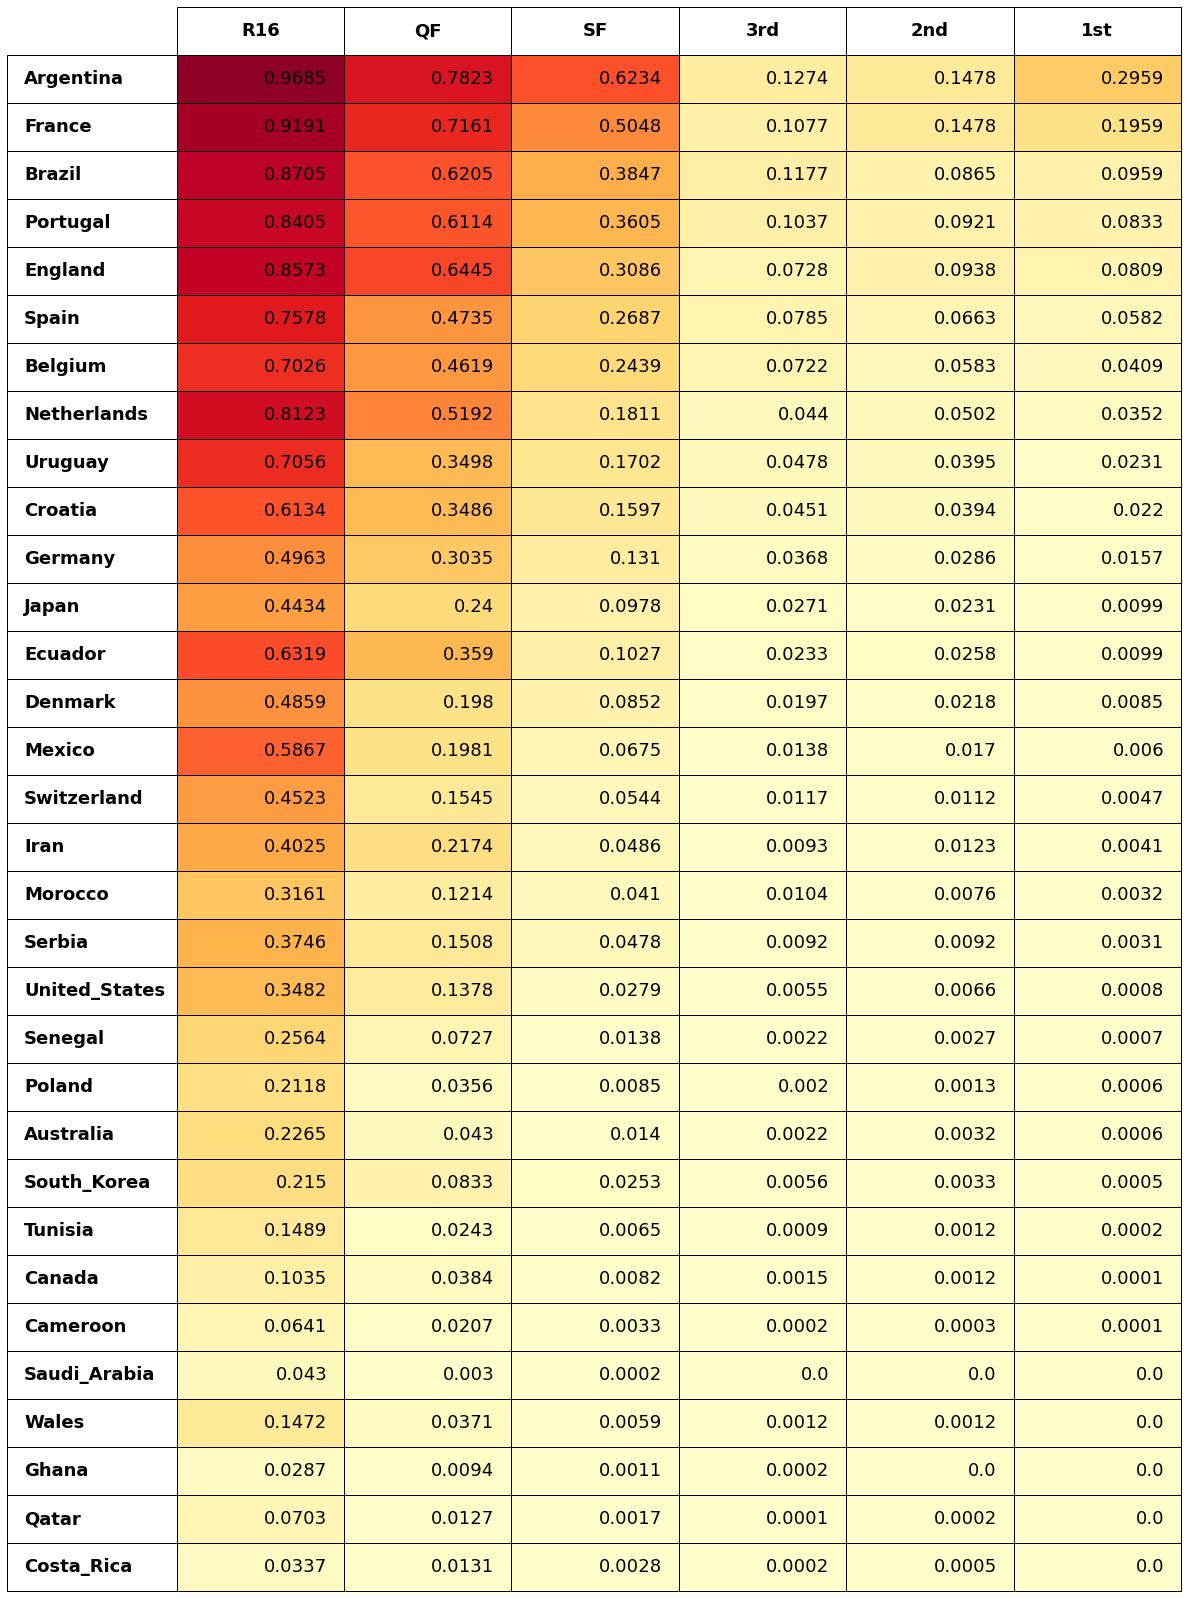

In [20]:
fig, ax = plt.subplots(1, 1, facecolor='white')
ax.axis('off')
ax.axis('tight')
table = ax.table(cellText=sorted_finish.values, cellColours=plt.cm.YlOrRd(sorted_finish.values),
                 rowLabels=sorted_finish.index, colLabels=sorted_finish.columns, 
                 loc='center')
table.auto_set_font_size(False)
table.set_fontsize(18)
table.scale(3, 4)

# ab = AnnotationBbox(getImage("./country-flags-main/png1000px/ar.png"), (200, 1837), 
#                     frameon=False, xycoords='figure points')
# ax.add_artist(ab)


for val in range(0,6):
    head = table[0,val]
    head.set_text_props(fontsize=18, fontweight='bold', verticalalignment='center')

for val in range(1,33):
    head = table[val,-1]
    head.set_text_props(fontsize=18, fontweight='bold', verticalalignment='center')

    
plt.show()

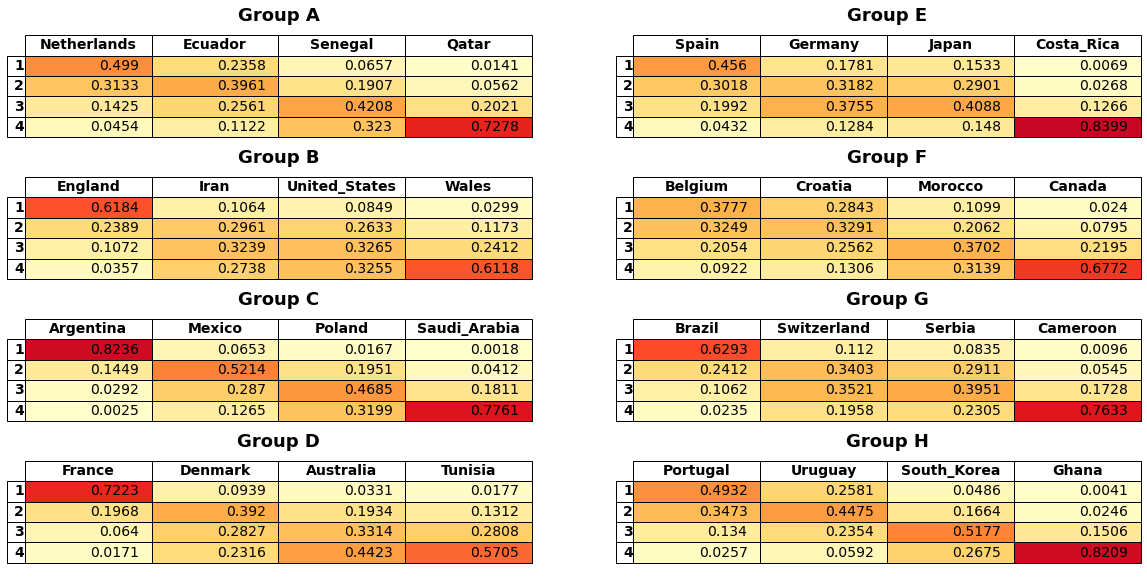

In [21]:
fig, ax = plt.subplots(4, 2, figsize=(20,10), facecolor='white')

for val in range(0,8):
    
    group = groups[val]
    
    pct_fin_group = percent_finish[group].sort_values(1, axis=1, ascending=False)
    
    ax[val % 4][val//4].axis('off')
    ax[val % 4][val//4].axis('tight')
    
    ax[val % 4][val//4].set_title(f"Group {group}", fontsize=18, fontweight='bold')
    
    table = ax[val % 4][val//4].table(cellText=pct_fin_group.values, 
                                     cellColours=plt.cm.YlOrRd(pct_fin_group.values),
                                     rowLabels=pct_fin_group.index, colLabels=pct_fin_group.columns, 
                                     loc='center')
    table.scale(1,1.7)
    
    table.auto_set_font_size(False)
    table.set_fontsize(14)
    
    for val in range(1,5):
        row = table[val,-1]
        row.set_text_props(fontsize=14, fontweight='bold', verticalalignment='center')
        row.PAD = 0.4

        head = table[0,val-1]
        head.set_text_props(fontsize=14, fontweight='bold', verticalalignment='center')

    
    